In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"

# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.devices()

In [113]:
import jax
import optax

import demes, demesdraw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi, optax_step
from momi3.utils import bootstrap_sample

import sys
import re
import math
import pickle
import tskit

import jax.numpy as jnp

from ast import literal_eval
from tqdm.notebook import trange
from train import get_demo, get_params

from scipy import stats

In [123]:
dissertation_dir = '../../PhD-Dissertation/'

In [114]:
sys.path.append('..')

In [115]:
from Timing_util import add_captions

In [126]:
df = []

bss = [False] + 5 * [True]
qs = [None, 0.95, 0.99, 0.9975, 0.999, 1.0]

for q, bs in zip(qs, bss):
    for i in range(100):
        if bs:
            name = f"seed_{i}_bound_{bs}_q={q}.csv"
        else:
            name = f"seed_{i}_bound_{bs}.csv"

        with open('bootstrap_acc/' + name, 'rb') as f:
            history = pickle.load(f)
            ind = np.argmin(history['LLs'])
            ttd = history['ttds'][ind]
            ttd = {i: float(ttd[i]) for i in ttd}
            d = {'bs': bs, 'q':q, 'i':i, 'LL': float(history['LLs'][ind])} | ttd
            df.append(d)
df = pd.DataFrame(df)
df['pi_0'] = 100 * df['pi_0']
df = df.fillna('No Sampler')

In [127]:
df = df.sort_values(['q', 'i']).reset_index(drop=True)

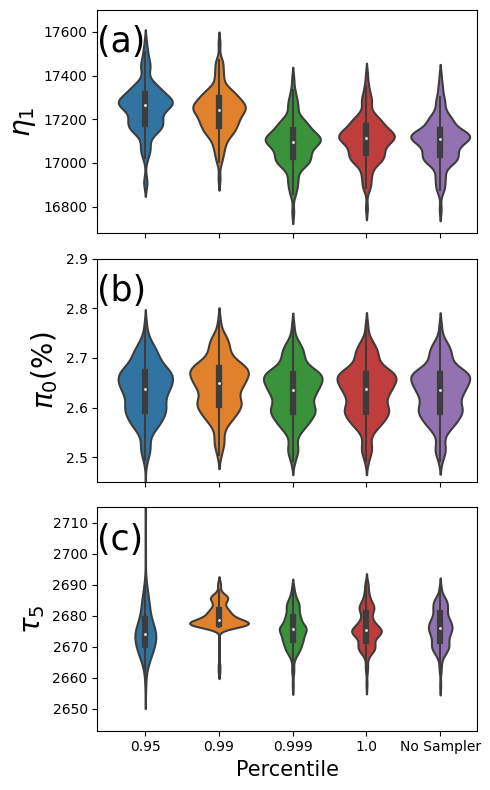

In [128]:
figure_name = 'violin_bs_estimates'

fig, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True)


bounds = {'eta_1': (None, 17700), 'pi_0': (2.45, 2.9), 'tau_5': (None, 2715)}

letters = iter(['a', 'b', 'c'])

axs = iter(axs)
for x in ['eta_1', 'pi_0', 'tau_5']:
    ax = next(axs)
    sns.violinplot(
        data=df, x="q", y=x, bw=.25,
        order=[0.95, 0.99, 0.999, 1.0, 'No Sampler'],
        showfliers=False, 
        ax=ax
    )
    if x[:2] == 'pi':
        lab = f"$\{x}$(%)"
    else:
        lab = f"$\{x}$"
    ax.set_ylim(bounds[x])
    ax.set_xlim(-0.65, None)
    ax.set_ylabel(lab, size=20)
    ax.set_xlabel(None)
    l = next(letters)
    ax.text(0., 0.81, f'({l})', transform=ax.transAxes, fontsize=25)

plt.xlabel('Percentile', fontsize=15)
plt.tight_layout()
plt.savefig(f"{dissertation_dir}figures/chapter3/{figure_name}.pdf", format="pdf", bbox_inches="tight", dpi=600)



In [130]:
for var in ['eta_1', 'pi_0', 'tau_5']:
    v = df[df['q'] == 'No Sampler'][var].to_numpy()
    df[f"APE{var}"] = df.groupby('q')[var].apply(lambda x: x-v)

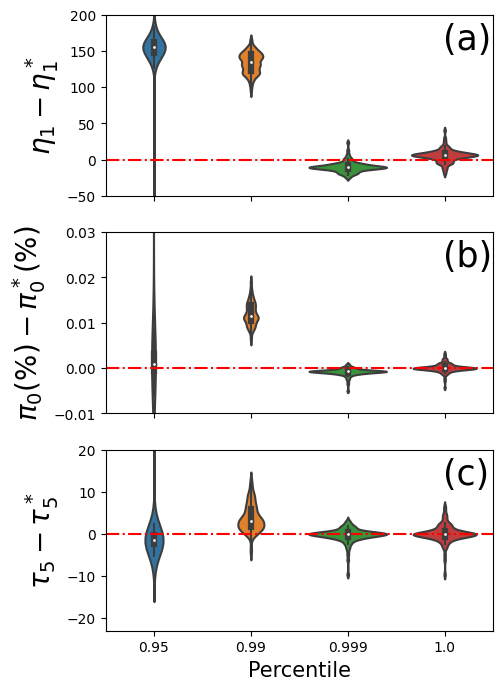

In [131]:
figure_name = 'violin_bs_bias'


fig, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True)


bounds = {'eta_1': (-50, 200), 'pi_0': (-0.01, 0.03), 'tau_5': (None, 20)}

letters = iter(['a', 'b', 'c'])

axs = iter(axs)
for x in ['eta_1', 'pi_0', 'tau_5']:
    ax = next(axs)
    sns.violinplot(
        data=df, x="q", y="APE"+x, bw=.25,
        order=[0.95, 0.99, 0.999, 1.0],
        showfliers=False, 
        ax=ax
    )
    if x[:2] == 'pi':
        lab = f"$\{x}(\%)-\{x}^*(\%)$"
    else:
        lab = f"$\{x}-\{x}^*$"
    ax.set_ylim(bounds[x])
    ax.set_ylabel(lab, size=20)
    ax.set_xlabel(None)
    ax.axhline(0., linestyle='-.', color='red')
    l = next(letters)
    ax.text(0.87, .81, f'({l})', transform=ax.transAxes, fontsize=25)

plt.xlabel('Percentile', fontsize=15)
plt.savefig(f"{dissertation_dir}figures/chapter3/{figure_name}.pdf", format="pdf", bbox_inches="tight", dpi=600)



# Effect on grad time

## Simplified Admixture demo

In [4]:
demo = demes.load('arc5_pulse_inferred.yaml')

ddict = demo.asdict()
dem = ddict['demes']
pul = ddict['pulses']
dem[7]['ancestors'] = ['ancestral']
dem[7]['start_time'] = 12500
dem = [dem[0], dem[1], dem[2],  dem[3], dem[4], dem[7], dem[8]]
pul = [pul[0]]
ddict['demes'] = dem
ddict['pulses'] = pul
demo = demes.Builder.fromdict(ddict).resolve()

In [5]:
ts = tskit.load('/mnt/turbo/eneswork/Unified_genome/hgdp_tgp_sgdp_high_cov_ancients_chr20_p.dated.trees')
deme_ids = {'Yoruba': 64, 'French': 16, 'Vindija': 214}
sampled_demes = tuple(deme_ids)

In [6]:
sampled_demes = tuple(deme_ids)

In [15]:
(jsfs != 0).sum()/2

6832.0

In [7]:
samples = [ts.samples(deme_ids[pop]) for pop in sampled_demes]
jsfs = ts.allele_frequency_spectrum(samples, polarised=True, span_normalise=False)
sample_sizes = [i - 1 for i in jsfs.shape]

In [16]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True, batch_size=6835, low_memory=True)

In [9]:
params = momi._default_params
params.set_train('tau_5', True)
params.set_train('pi_0', True)
params.set_train('eta_1', True)

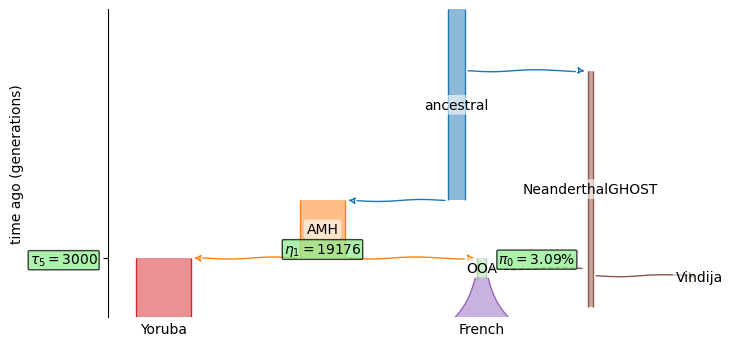

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
params.tubes(True, True, hide_non_inferreds=True, 
             tau_keys=['tau_5'], ax=ax)
plt.savefig(f"{dissertation_dir}figures/chapter3/demo/3poparc.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [17]:
def ftime():
    momi.negative_loglik_with_gradient(params, jsfs)

In [18]:
from timeit import repeat

In [25]:
comp_times = {}
runtimes = {}

In [19]:
no_sampler_times = repeat(ftime, repeat=11, number=1)

In [26]:
comp_times['No Sampler'] = no_sampler_times[0]
runtimes['No Sampler'] = np.mean(no_sampler_times[1:])

# Bound Sampler

In [118]:
caption = "Bound Sampler Runtime"
tlabel = 'tbl:ch3:bs_runtimes'

In [119]:
def get_momi_b(q):
    momi_b = Momi(demo, sampled_demes, sample_sizes, jitted=True)
    bounds = momi_b.bound_sampler(params, 10000, min_lineages=2, seed=108, quantile=q)
    momi_b = momi_b.bound(bounds)
    return momi_b

In [120]:
for q in [0.95, 0.99, 0.999, 1.0]:
    momi_b = get_momi_b(q)
    def ftime():
        momi_b.negative_loglik_with_gradient(params, jsfs)
        
    times = repeat(ftime, repeat=11, number=1)
    comp_times[str(q)] = times[0]
    runtimes[str(q)] = np.mean(times[1:])

In [121]:
dbs = pd.DataFrame([pd.Series(comp_times), pd.Series(runtimes)]).T
dbs = dbs.reindex(['No Sampler', '1.0', '0.999', '0.99', '0.95'])
dbs = dbs.style.format('{:.3f}').to_latex()

In [122]:
x = dbs.split(split_line)
x[0] = '\\begin{tabular}{l|rr}\n\\bfseries Percentile & Compilation Time & Runtime $\\nabla\ell$ '
x = split_line.join(x)
x = add_captions(x, caption, tlabel)

In [124]:
text_file = open(f"{dissertation_dir}tables/bs_timing.tex", "w")
n = text_file.write(x)
text_file.close()